### Query prompt

* `Prompt Query Mecanism` de Segment Any Change
* N prompt utilisateur en paramètres (3 par défaut) - (symbol *étoile* sur les samples)
* Les objets des prompts sont matchés (cosine sim) avec les objets de changements extraits via le Bitemporal Matching : on obtient **les objets de changements similaire sémantiquement**

#### Remarques
* coût mémoire entre vit_b et vit_h pas tres différents (+~100Gb): il semble que cela soit les calculs d'attentions dans le décodeur qui soient tres couteuses voir torch profile
* Paramétrage de SAM donne une forte variabilité de résultats (exhaustivité des masques à controler via *pred_iou_thresh* et *stability_score_thresh*)
* Objets de changements extraits via BitemporalMatching via seuil angle de changement *th_change_proposals*
* Similarité de changement sémantique fixée à 0.8 (arbitraire)

In [6]:
import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from dataclasses import asdict
from torch.profiler import profile, record_function, ProfilerActivity


from src.commons.constants import NamedDataset, NamedModels
from src.commons.constants import SEED, DEVICE
from src.commons.utils_io import save_pickle, load_pickle
#from src.commons.inference import partial_inference, infer_on_sample, load_partial_ds
from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample

from src.models.commons.choose_model import choose_model
from src.models.commons.model import BiSam
from src.models.commons.mask_process import extract_object_from_batch

from src.data.loader import BiTemporalDataset, load_levircd_sample
from src.data.process import DefaultTransform

from src.models.segment_any_change.query_prompt import SegAnyPrompt
from src.models.segment_any_change.matching import BitemporalMatching
from src.models.segment_any_change.config_run import load_sam, load_default_exp_params, ExperimentParams, load_default_metrics, load_exp_params


pl.seed_everything(seed=SEED)

Seed set to 12


12

In [2]:
ds_dtype = "train"

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=60,
    prompt_type="sample",
    n_prompt=3,
    loc="random",
    pred_iou_thresh=0.8,
    stability_score_thresh=0.8,
    n_points_grid=1024,
    th_sim=0.7,
    model_name=NamedModels.SEGANYPROMPT.value
)
params = load_exp_params(**params)
print(params)

ExperimentParams(model_name='seganyprompt', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_b', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th/vit_b', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.7, n_points_grid=32, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.8, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240703_110454', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


In [3]:
indices = np.arange(4)
# indices = [71, 115, 54, 46]
print(indices)
#

ds = load_partial_ds(params.ds_name, ds_dtype, params, indices)

dloader = torch.utils.data.DataLoader(
    ds, batch_size=params.batch_size, shuffle=False
)

sam = load_sam(
    model_type=params.model_type, model_cls=BiSam, version="dev", device=DEVICE
)
matching_engine = BitemporalMatching(
            model=sam,
            version=params.seganychange_version,
            **asdict(params)
        )
print(f"len ds : {len(ds)}")
engine = SegAnyPrompt(matching_engine, **asdict(params))
outputs = []
for i, batch in tqdm(enumerate(dloader), total=len(dloader), desc="Processing"):
    with torch.no_grad():
        with profile(activities=[ProfilerActivity.CPU],profile_memory=True, record_shapes=True) as prof:
            preds = engine(batch)
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

        outputs.append({"pred":preds, "batch":batch})

2024-07-03 11:04:54,788 - INFO ::  build vit_b BiSam


[0 1 2 3]
DATASET SUBSET : 4
len ds : 4


Processing:   0%|                                                                                                                                              | 0/2 [00:00<?, ?it/s][W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
2024-07-03 11:04:59,448 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : SamModeInference.AUTO
DTYPE input model torch.float32
Function forward Took 7.2898 seconds
sparse_embeddings: torch.Size([4, 25, 2, 256])
dense_embeddings: torch.Size([4, 25, 256, 64, 64])
--in transformer--
src : torch.Size([4, 25, 256, 64, 64])
pos_src : torch.Size([4, 25, 256, 64, 64])
tokens : torch.Size([4, 25, 7, 256])


2024-07-03 11:05:08,939 - INFO ::  Function generate Took 9.4904 seconds


Function predict_masks_batch Took 2.1291 seconds
OUT MODEL : torch.Size([4, 25, 3, 256, 256])
:: raw masks : 75 ::
 filter iou_th : 32
 filter stability_score : 22
 filter mask_threshold : 22
ATTACH 19 masks
:: raw masks : 75 ::
 filter iou_th : 26
 filter stability_score : 10
 filter mask_threshold : 10
ATTACH 9 masks
:: raw masks : 75 ::
 filter iou_th : 26
 filter stability_score : 19
 filter mask_threshold : 19
ATTACH 14 masks
:: raw masks : 75 ::
 filter iou_th : 33
 filter stability_score : 12
 filter mask_threshold : 12
ATTACH 11 masks


2024-07-03 11:05:09,338 - INFO ::  Function temporal_matching_torch Took 0.3931 seconds
2024-07-03 11:05:09,626 - INFO ::  Function temporal_matching_torch Took 0.2869 seconds
2024-07-03 11:05:09,631 - INFO ::  Function proposal_matching_nms Took 0.0030 seconds


NMS masks fusion
masks torch.Size([2, 19, 256, 256])
masks i A torch.Size([19, 256, 256])
masks i B torch.Size([14, 256, 256])
ci torch.Size([2, 19])
bboxes torch.Size([2, 19, 4])
ious torch.Size([2, 19])
masks_logits torch.Size([2, 19, 256, 256])
chgt_angle
torch.Size([33])
thresholding : 60 for chgt_angle
torch.Size([13])


2024-07-03 11:05:09,836 - INFO ::  Function temporal_matching_torch Took 0.1934 seconds
2024-07-03 11:05:10,064 - INFO ::  Function temporal_matching_torch Took 0.2280 seconds
2024-07-03 11:05:10,067 - INFO ::  Function proposal_matching_nms Took 0.0008 seconds
2024-07-03 11:05:10,093 - INFO ::  Function run Took 10.6443 seconds


NMS masks fusion
masks torch.Size([2, 11, 256, 256])
masks i A torch.Size([9, 256, 256])
masks i B torch.Size([11, 256, 256])
ci torch.Size([2, 11])
bboxes torch.Size([2, 11, 4])
ious torch.Size([2, 11])
masks_logits torch.Size([2, 11, 256, 256])
chgt_angle
torch.Size([18])
thresholding : 60 for chgt_angle
torch.Size([9])
Mode : SamModeInference.INTERACTIVE
torch.Size([2, 3, 2])
DTYPE input model torch.float32
Function forward Took 3.3933 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.2020 seconds
thresholding : 0.7 for sim
thresholding : 0.7 for sim


Processing:  50%|███████████████████████████████████████████████████████████████████                                                                   | 1/2 [00:19<00:19, 19.69s/it]

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::add        11.90%        1.651s        11.90%        1.652s       7.245ms      45.67 Gb      45.67 Gb           228  
                      aten::bmm        13.85%        1.922s        13.85%        1.922s      15.257ms      22.85 Gb      22.85 Gb           126  
                    aten::empty         0.07%      10.102ms         0.07%      10.102ms       9.808us      22.71 Gb      22.71 Gb          1030  
                 aten::_softmax         5.41%     751.049ms         5.41%     751.049ms      19.764ms      20.51 Gb      20.

[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
2024-07-03 11:05:17,596 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : SamModeInference.AUTO
DTYPE input model torch.float32
Function forward Took 6.6263 seconds
sparse_embeddings: torch.Size([4, 25, 2, 256])
dense_embeddings: torch.Size([4, 25, 256, 64, 64])
--in transformer--
src : torch.Size([4, 25, 256, 64, 64])
pos_src : torch.Size([4, 25, 256, 64, 64])
tokens : torch.Size([4, 25, 7, 256])


2024-07-03 11:05:26,563 - INFO ::  Function generate Took 8.9660 seconds


Function predict_masks_batch Took 2.2929 seconds
OUT MODEL : torch.Size([4, 25, 3, 256, 256])
:: raw masks : 75 ::
 filter iou_th : 35
 filter stability_score : 22
 filter mask_threshold : 22
ATTACH 18 masks
:: raw masks : 75 ::
 filter iou_th : 36
 filter stability_score : 13
 filter mask_threshold : 13
ATTACH 11 masks
:: raw masks : 75 ::
 filter iou_th : 18
 filter stability_score : 16
 filter mask_threshold : 16
ATTACH 15 masks
:: raw masks : 75 ::
 filter iou_th : 29
 filter stability_score : 10
 filter mask_threshold : 10
ATTACH 9 masks


2024-07-03 11:05:26,872 - INFO ::  Function temporal_matching_torch Took 0.3066 seconds
2024-07-03 11:05:27,135 - INFO ::  Function temporal_matching_torch Took 0.2620 seconds
2024-07-03 11:05:27,138 - INFO ::  Function proposal_matching_nms Took 0.0012 seconds


NMS masks fusion
masks torch.Size([2, 18, 256, 256])
masks i A torch.Size([18, 256, 256])
masks i B torch.Size([15, 256, 256])
ci torch.Size([2, 18])
bboxes torch.Size([2, 18, 4])
ious torch.Size([2, 18])
masks_logits torch.Size([2, 18, 256, 256])
chgt_angle
torch.Size([34])
thresholding : 60 for chgt_angle
torch.Size([13])


2024-07-03 11:05:27,344 - INFO ::  Function temporal_matching_torch Took 0.2023 seconds
2024-07-03 11:05:27,522 - INFO ::  Function temporal_matching_torch Took 0.1775 seconds
2024-07-03 11:05:27,525 - INFO ::  Function proposal_matching_nms Took 0.0009 seconds
2024-07-03 11:05:27,544 - INFO ::  Function run Took 9.9475 seconds


NMS masks fusion
masks torch.Size([2, 11, 256, 256])
masks i A torch.Size([11, 256, 256])
masks i B torch.Size([9, 256, 256])
ci torch.Size([2, 11])
bboxes torch.Size([2, 11, 4])
ious torch.Size([2, 11])
masks_logits torch.Size([2, 11, 256, 256])
chgt_angle
torch.Size([20])
thresholding : 60 for chgt_angle
torch.Size([3])
Mode : SamModeInference.INTERACTIVE
torch.Size([2, 3, 2])
DTYPE input model torch.float32
Function forward Took 3.1367 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.2001 seconds
thresholding : 0.7 for sim
thresholding : 0.7 for sim


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:37<00:00, 18.58s/it]

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::add        10.52%        1.359s        10.52%        1.359s       5.962ms      45.67 Gb      45.67 Gb           228  
                      aten::bmm        12.42%        1.605s        12.43%        1.606s      12.742ms      22.85 Gb      22.85 Gb           126  
                    aten::empty         0.08%      10.587ms         0.08%      10.587ms      10.249us      21.56 Gb      21.56 Gb          1033  
                 aten::_softmax         4.71%     608.694ms         4.71%     608.694ms      16.018ms      20.51 Gb      20.

---

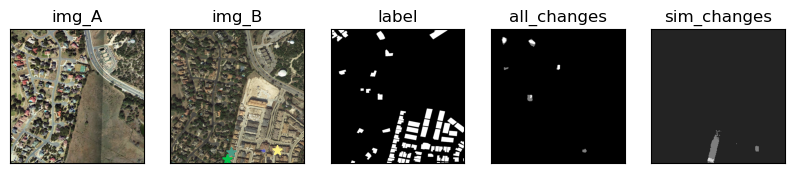

In [4]:
output = outputs[1]
idx = 0
masks = output["pred"]["masks"].cpu().squeeze(0)
img_A = output["batch"]["img_A"].cpu().squeeze(0)
img_B = output["batch"]["img_B"].cpu().squeeze(0)
label = output["batch"]["label"].cpu().squeeze(0)
#raw_masks = output["pred"]["raw_masks"].cpu().squeeze(0)
masks_change = output["pred"]["all_changes"].cpu().squeeze(0)

prompts = output["batch"]["point_coords"].cpu().squeeze(0)

if idx is not None:
    masks = masks[idx].squeeze(0)
    img_A = img_A[idx].squeeze(0)
    img_B = img_B[idx].squeeze(0)
    label = label[idx].squeeze(0)
    prompts = prompts[idx].squeeze(0)
    #raw_masks = raw_masks[idx].squeeze(0)
    masks_change = masks_change[idx].squeeze(0)

if masks.ndim == 3:
    masks = torch.sum(masks, dim=0)
    #raw_masks = torch.sum(raw_masks, dim=0)
    masks_change = torch.sum(masks_change, dim=0)

imgs = [img_A, img_B, label, masks_change, masks]
names = ["img_A", "img_B", "label", "all_changes", "sim_changes"]

fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
for i, sample in enumerate(
    zip(imgs, names)
):
    img, name = sample
    if name.startswith("im"):
        img = to_numpy(img, transpose=True) / 255
        axs[0, i].imshow(img)

    else:
        img = to_numpy(img, transpose=False)
        axs[0, i].imshow(img, cmap="grey")

    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, i].set_title(name)
    if name == "img_B":
        if prompts.shape[0] < 100: # prevent showing grid
            colors = [np.random.choice(range(256), size=3) / 255 for _ in range(len(prompts))]
            for pt,c in zip(prompts, colors):
                axs[0, i].scatter(*pt, color=c, marker='*', s=50)


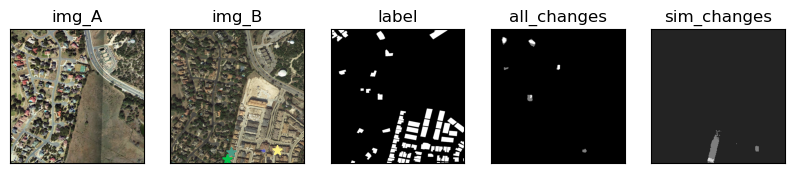

In [10]:
# create the subfigures and subplots
fig = plt.figure(figsize=(20, 20), constrained_layout=True)
subfigs = fig.subfigures(1, 3, width_ratios=[1, 1, 1], wspace=.15)

axs0 = subfigs[0].subplots(5, 2)
axs0 = axs0.flatten()
subfigs[0].suptitle('Mean Values', fontsize=20)


In [14]:
from src.commons.eval import MetricEngine, UnitsMetricCounts
from src.commons.utils import create_grid_batch

confmat_units = MetricEngine(
            [UnitsMetricCounts()], prefix="", name="units", **params.engine_metric
        )

In [15]:
preds, label = output["pred"], batch["label"]

tp, fp, fn, tn = confmat_units(preds, label).values()

update : units


In [16]:
img = create_grid_batch(preds["masks"], batch, tp, fp, fn)

In [21]:
plt.imshow(to_numpy(img))
fig = plt.gca().get_figure()
plt.close()

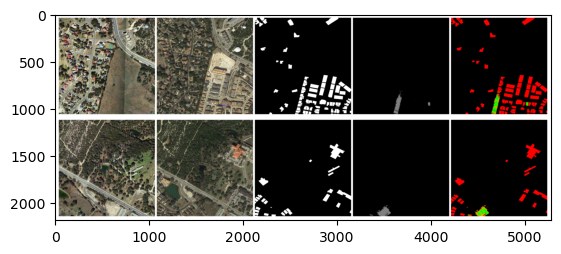

In [22]:
fig

In [24]:
# create a numpy 1d-array
x = np.ones((1024, 1024))
 
print("Size of the array: ",
      x.size)
 
print("Memory size of one array element in bytes: ",
      x.itemsize)
 
# memory size of numpy array in bytes
print("Memory size of numpy array in MB:",
      (x.size * x.itemsize)*1000/ (1_000_000 *1000))

Size of the array:  1048576
Memory size of one array element in bytes:  8
Memory size of numpy array in MB: 8.388608


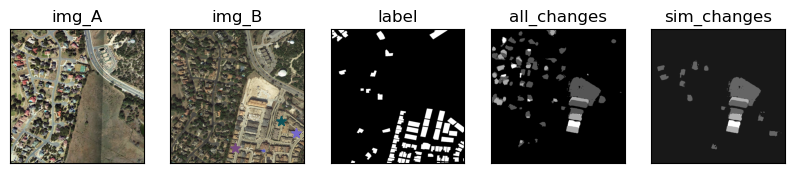

In [8]:
show_prediction_sample(outputs[1], idx=0)

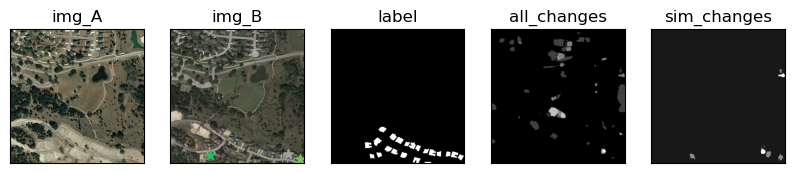

In [9]:
show_prediction_sample(outputs[0], idx=0)

## ViT-h

### 3

In [46]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.8, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_180123', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False, loc='random')


tensor([394., 943.])
tensor([467.,  26.])
tensor([128.,   7.])


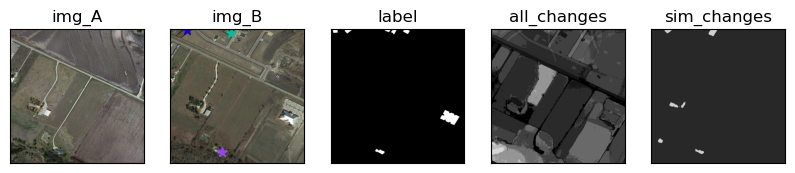

In [47]:
show_prediction_sample(outputs[0], idx=0)

tensor([ 20., 866.])
tensor([ 42., 464.])
tensor([ 34., 822.])


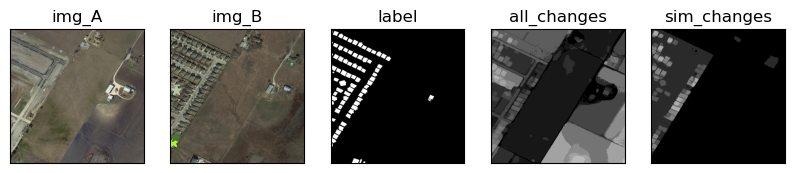

In [48]:
show_prediction_sample(outputs[0], idx=1)

tensor([550., 580.])
tensor([427., 730.])
tensor([198., 772.])


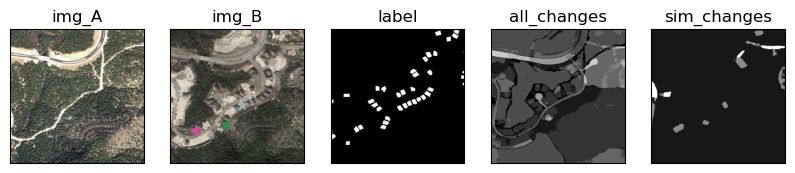

In [49]:
show_prediction_sample(outputs[1], idx=0)

tensor([596., 401.])
tensor([413., 418.])
tensor([223., 430.])


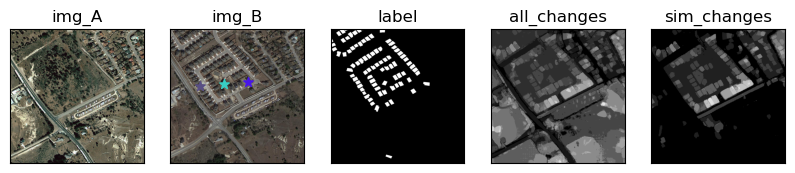

In [50]:
show_prediction_sample(outputs[1], idx=1)

### 2 

In [39]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_175606', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False, loc='random')


tensor([873., 604.])
tensor([1006.,  211.])
tensor([914., 598.])


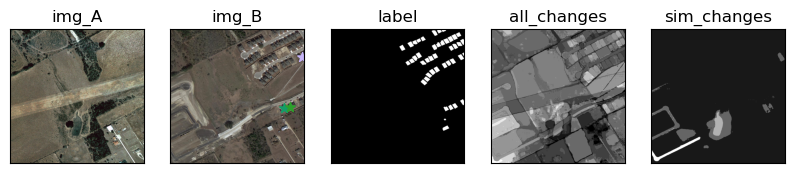

In [40]:
show_prediction_sample(outputs[0], idx=0)

tensor([757., 845.])
tensor([73., 60.])
tensor([897., 625.])


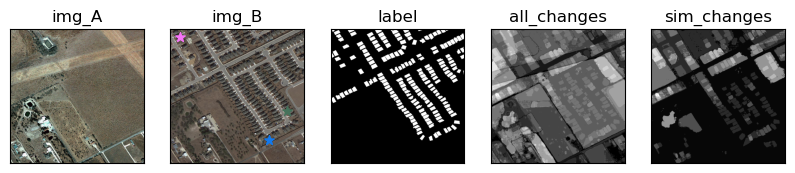

In [41]:
show_prediction_sample(outputs[0], idx=1)

tensor([696., 744.])
tensor([746., 148.])
tensor([965., 700.])


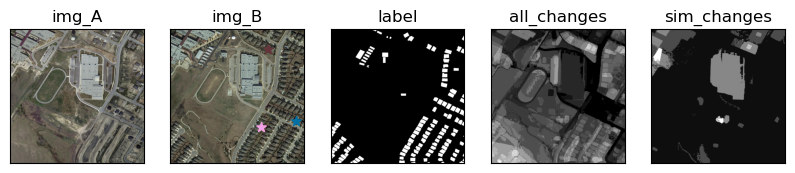

In [42]:
show_prediction_sample(outputs[1], idx=0)

tensor([581.,  25.])
tensor([392., 936.])
tensor([474.,  23.])


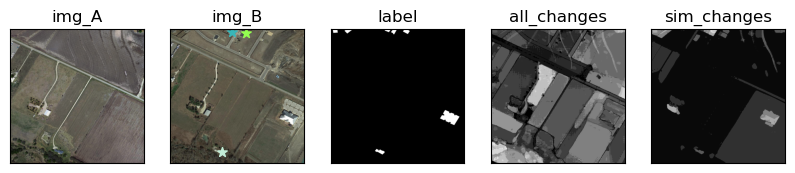

In [43]:
show_prediction_sample(outputs[1], idx=1)

### 1

In [32]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_175111', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False, loc='random')


tensor([ 884., 1018.])
tensor([854., 936.])
tensor([817., 955.])


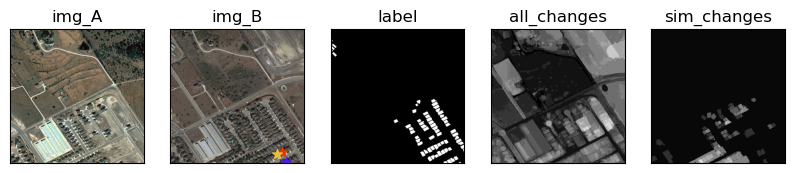

In [33]:
show_prediction_sample(outputs[0], idx=0)

tensor([245., 473.])
tensor([696., 830.])
tensor([969., 211.])


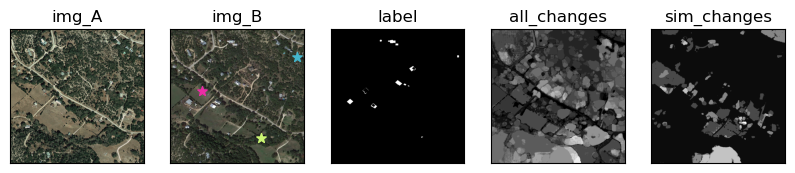

In [34]:
show_prediction_sample(outputs[0], idx=1)

tensor([737., 669.])
tensor([802., 981.])
tensor([748., 929.])


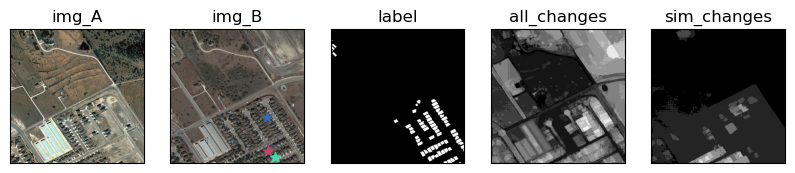

In [35]:
show_prediction_sample(outputs[1], idx=0)

tensor([435., 844.])
tensor([ 426., 1019.])
tensor([141., 672.])


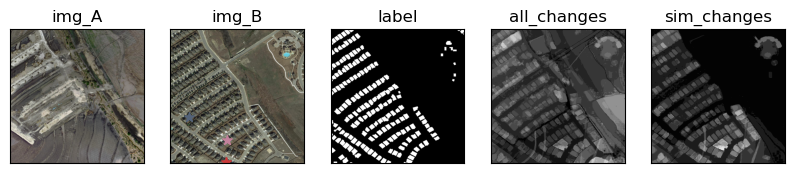

In [36]:
show_prediction_sample(outputs[1], idx=1)

## VIT-b

### 4

In [23]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_173446', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([809., 831.])
tensor([857., 858.])
tensor([546., 887.])


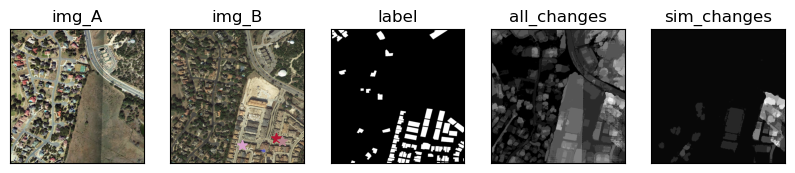

In [24]:
show_prediction_sample(outputs[0], idx=0)

tensor([ 40., 976.])
tensor([876., 921.])
tensor([ 189., 1018.])


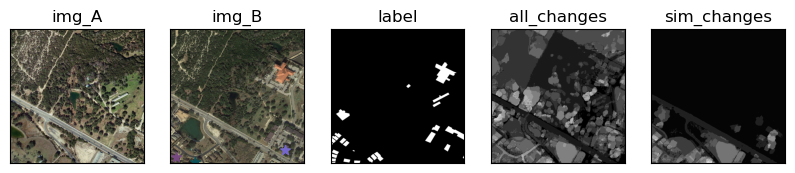

In [25]:
show_prediction_sample(outputs[0], idx=1)

tensor([605.,  76.])
tensor([938.,  60.])
tensor([736.,  65.])


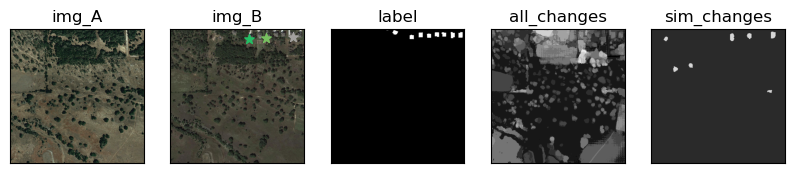

In [26]:
show_prediction_sample(outputs[1], idx=0)

tensor([941., 168.])
tensor([835., 127.])
tensor([875., 127.])


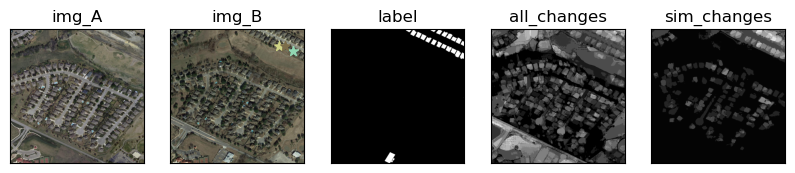

In [27]:
show_prediction_sample(outputs[1], idx=1)

### 3

In [12]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_172224', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])


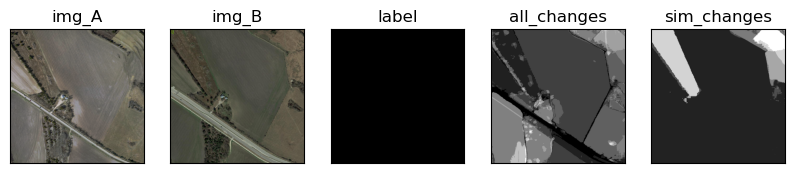

In [13]:
show_prediction_sample(outputs[0], idx=0)

tensor([267., 983.])
tensor([381., 398.])
tensor([  9., 613.])


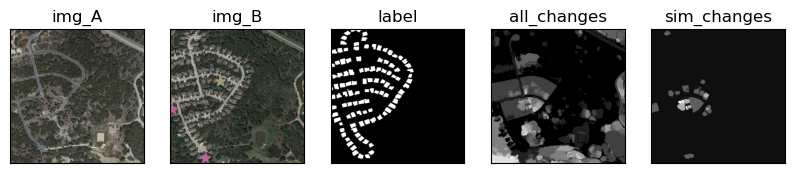

In [14]:
show_prediction_sample(outputs[0], idx=1)

tensor([100.,  83.])
tensor([ 69., 104.])
tensor([113.,  48.])


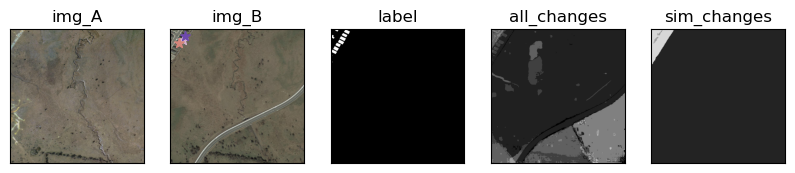

In [15]:
show_prediction_sample(outputs[1], idx=0)

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])


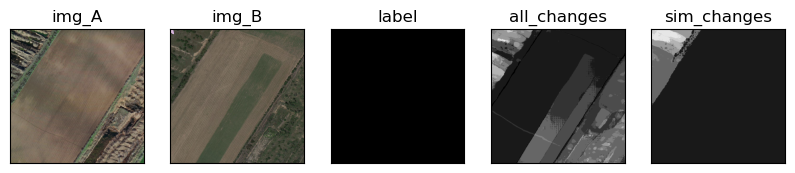

In [16]:
show_prediction_sample(outputs[1], idx=1)

### 2

In [9]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_171122', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([807., 856.])
tensor([393., 174.])
tensor([903.,  97.])


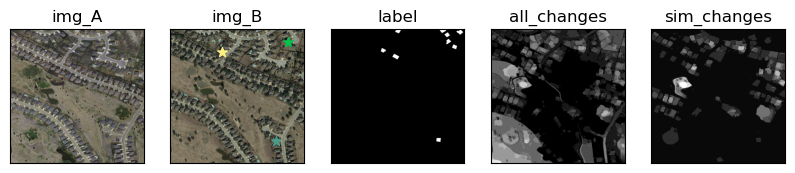

In [10]:
show_prediction_sample(outputs[0], idx=0)

tensor([85., 51.])
tensor([80., 62.])
tensor([57., 52.])


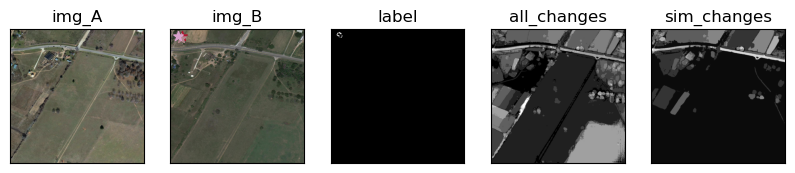

In [11]:
show_prediction_sample(outputs[0], idx=1)

tensor([111., 509.])
tensor([ 928., 1001.])
tensor([882., 922.])


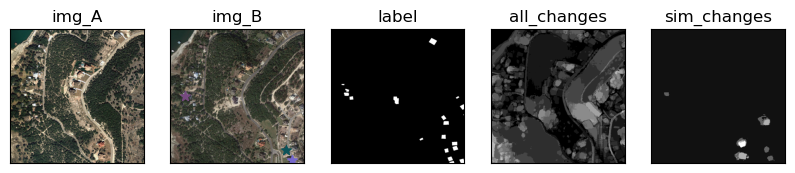

In [12]:
show_prediction_sample(outputs[1], idx=0)

tensor([506., 764.])
tensor([261., 822.])
tensor([172., 783.])


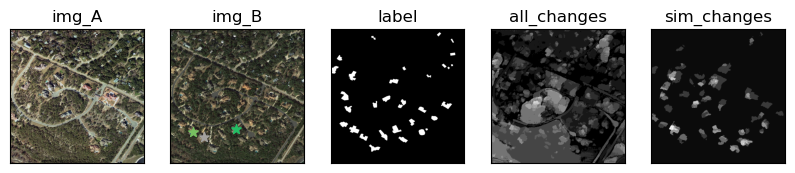

In [13]:
show_prediction_sample(outputs[1], idx=1)

### 1

In [22]:
print(params)

ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_165330', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([813., 850.])
tensor([896.,  47.])
tensor([933., 144.])


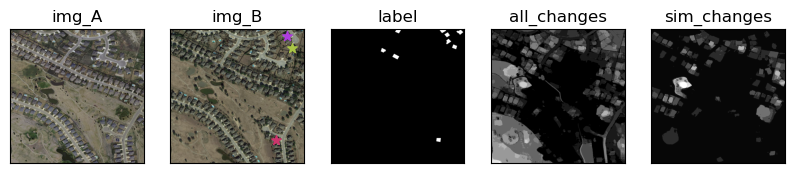

In [23]:
show_prediction_sample(outputs[0], idx=0)

tensor([57., 54.])
tensor([88., 52.])
tensor([80., 61.])


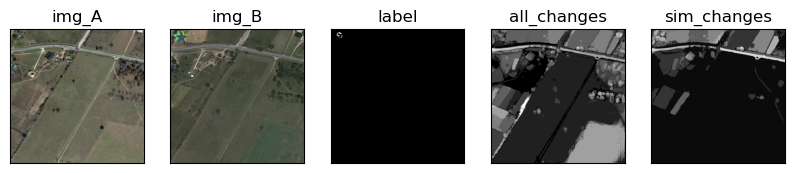

In [24]:
show_prediction_sample(outputs[0], idx=1)

tensor([913., 992.])
tensor([854., 825.])
tensor([884., 936.])


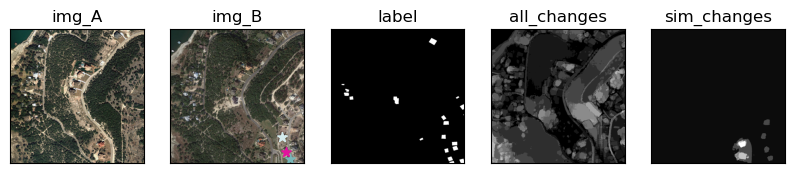

In [25]:
show_prediction_sample(outputs[1], idx=0)

tensor([462., 398.])
tensor([709., 782.])
tensor([902., 300.])


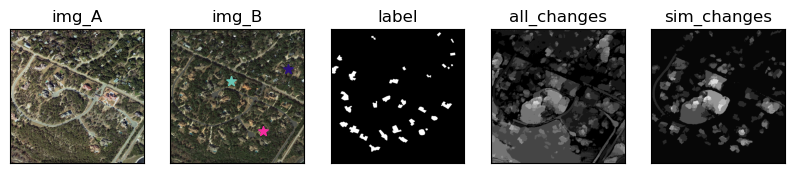

In [26]:
show_prediction_sample(outputs[1], idx=1)

# Annexes

In [4]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=50
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-19 14:34:50,256 - INFO ::  build vit_h BiSam


ExperimentParams(model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', points_per_side=32, points_per_batch=64, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240619_143450', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False)


2024-06-19 14:34:55,411 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
DTYPE input model torch.float32
Function forward Took 16.2692 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
Function predict_masks_batch Took 32.6380 seconds
OUT MODEL : torch.Size([2, 1024, 3, 256, 256])
filter iou_th : 2037
 filter stability_score : 576
 filter mask_threshold : 576
ATTACH 110 masks


2024-06-19 14:35:44,650 - INFO ::  Function generate Took 49.2381 seconds


filter iou_th : 1027
 filter stability_score : 456
 filter mask_threshold : 456
ATTACH 227 masks


2024-06-19 14:35:46,725 - INFO ::  Function temporal_matching_torch Took 2.0714 seconds
2024-06-19 14:35:50,998 - INFO ::  Function temporal_matching_torch Took 4.2717 seconds
2024-06-19 14:35:51,018 - INFO ::  Function proposal_matching_nms Took 0.0087 seconds


NMS masks fusion
masks torch.Size([2, 227, 256, 256])
masks i A torch.Size([110, 256, 256])
masks i B torch.Size([227, 256, 256])
ci torch.Size([2, 227])
bboxes torch.Size([2, 227, 4])
ious torch.Size([2, 227])
masks_logits torch.Size([2, 227, 256, 256])


2024-06-19 14:35:51,213 - INFO ::  Function run Took 55.8009 seconds


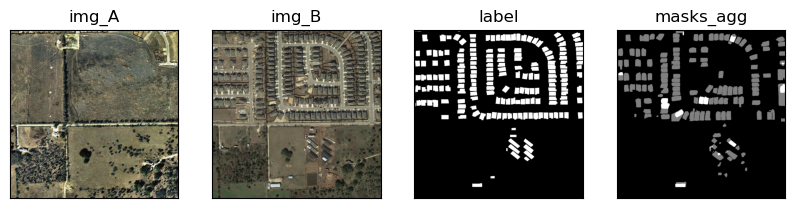

In [5]:
show_prediction_sample(output)

### Review sampler for training
* need to sample M point for N shapes. (M point per N shapes).
* Need to extract label corresponding to the candidates shapes

In [7]:
from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample
from src.models.commons.mask_process import extract_object_from_batch
import torch
from src.data.process import generate_grid_prompt
import numpy as np

import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

In [2]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":12,
    "loc": "center",
    "batch_size": 1,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [3]:
print("when n_shape is null")
print(ds[0]["point_coords"].shape)
print(ds[1]["point_coords"].shape)
print(ds[2]["point_coords"].shape)

when n_shape is null
/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
torch.Size([12, 2])
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48
torch.Size([12, 2])
/home/MDizier/data/dl/levir-cd/test/label/test_3.png
FIND SHAPES 7
torch.Size([12, 2])


=> need to modify collate_fn

In [4]:
from typing import List, Tuple, Dict, Any
def collate_align_prompt(input: List[Any]):

    prompt_pts = [d["point_coords"] for d in input]
    prompt_labels = [d["point_labels"] for d in input]

    # we set -1 as value to ignore prompt
    batch_pts = pad_sequence(prompt_pts, batch_first=True, padding_value=torch.inf)
    # negative prompt : 0 is ignore - (same as positive prompt btw)
    batch_labels = pad_sequence(prompt_labels, batch_first=True, padding_value=0)

    for i in range(len(input)):
        input[i]["point_coords"] = batch_pts[i]
        input[i]["point_labels"] = batch_labels[i]

    return data._utils.collate.default_collate(input)

In [5]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )

In [261]:
0 % 100_000

0

In [6]:
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12


In [7]:
batch["img_B"].shape

torch.Size([1, 3, 1024, 1024])

In [64]:
for k,v in batch.items():
    print(k)
    if isinstance(v, torch.Tensor):
        print(v.shape)
    else:
        print(len(v))
    print("-")

img_A
torch.Size([2, 3, 1024, 1024])
-
img_B
torch.Size([2, 3, 1024, 1024])
-
label
torch.Size([2, 1024, 1024])
-
label_path
2
-
index
torch.Size([2])
-
point_coords
torch.Size([2, 3, 2])
-
point_labels
torch.Size([2, 3])
-


### Try inference

In [9]:
import hydra
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

In [10]:
ls ../../configs

callbacks/  eval.yaml    hparams_search/  local/    model/     trainer/
data/       experiment/  hydra/           logger/   paths/     train.yaml
debug/      extras/      __init__.py      metrics/  sam_type/


In [11]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(config_name="train", overrides=["experiment=mp_naive", "sam_type=small", "data=levir-cd"])
    
    return cfg

In [12]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
cfg = load_config()
print(OmegaConf.to_yaml(cfg))

data:
  name: levir-cd
  _target_: src.data.datamodule.CDDataModule
  params:
    prompt_type: sample
    n_prompt: 1
    loc: center
    batch_size: 2
    n_shape: null
    num_worker: 8
model:
  network:
    image_encoder:
      _target_: src.models.segment_anything.modeling.image_encoder_dev.ImageEncoderViT
      depth: 12
      embed_dim: 768
      img_size: 1024
      mlp_ratio: 4
      norm_layer: null
      num_heads: 12
      patch_size: 16
      qkv_bias: true
      use_rel_pos: true
      global_attn_indexes:
      - 2
      - 5
      - 8
      - 11
      window_size: 14
      out_chans: 256
    prompt_encoder:
      _target_: src.models.segment_anything.modeling.prompt_encoder_dev.PromptEncoder
      embed_dim: 256
      image_embedding_size:
      - 64
      - 64
      input_image_size:
      - 1024
      - 1024
      mask_in_chans: 16
    mask_decoder:
      transformer:
        _target_: src.models.segment_anything.modeling.transformer_dev.TwoWayTransformer
        depth:

In [13]:
module = hydra.utils.instantiate(cfg.model.instance)

In [14]:
def load_ckpt_sam(sam, checkpoint=None):
    if checkpoint is not None:
        with open(checkpoint, "rb") as f:
            state_dict = torch.load(f)
        sam.load_state_dict(state_dict)
    return sam
    
model = load_ckpt_sam(module.model, checkpoint=cfg.get("sam_ckpt_path"))

In [15]:
y = batch["label"].to(torch.float)

In [16]:
preds, ious  = model(batch, multimask_output=False)

sparse_embeddings: torch.Size([1, 12, 2, 256])
dense_embeddings: torch.Size([1, 12, 256, 64, 64])


In [17]:
preds = preds > 0

In [19]:
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr
from typing import Any, Dict, List, Tuple, Union


In [19]:
preds.shape

torch.Size([1, 12, 1024, 1024])

In [173]:
def get_mask_with_prompt(img: Union[np.ndarray, torch.Tensor], coord_points: Union[np.ndarray, torch.Tensor]) -> np.ndarray:
    """
    show prompts points on img (binary image HxW)
    return np.ndarray
    """

    if isinstance(img, torch.Tensor):
        img = to_numpy(img, transpose=False)
    if isinstance(coord_points, torch.Tensor):
        coord_points = to_numpy(coord_points, transpose=False)

    show_img(img > 0)
    ax = plt.gca()
    colors = [
        np.random.choice(range(256), size=3) / 255
        for _ in range(len(coord_points))
        ]
    
    for pt,c in zip(coord_points, colors):
        ax.scatter(*pt, color=c, marker='*', s=30)
    
    fig=plt.gcf()
    plt.close()
    return fig2arr(fig)

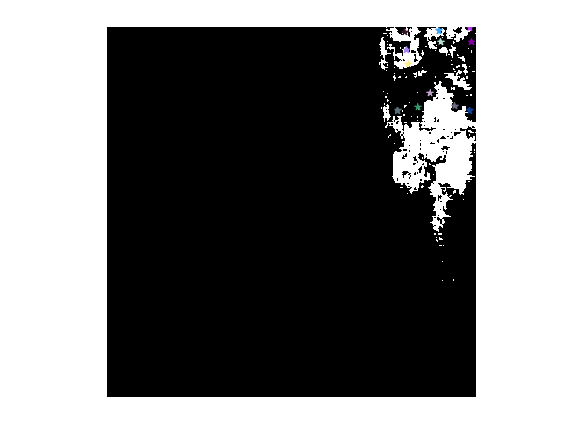

In [21]:
idx = 0
mask = torch.sum(preds[idx], dim=0) > 0
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

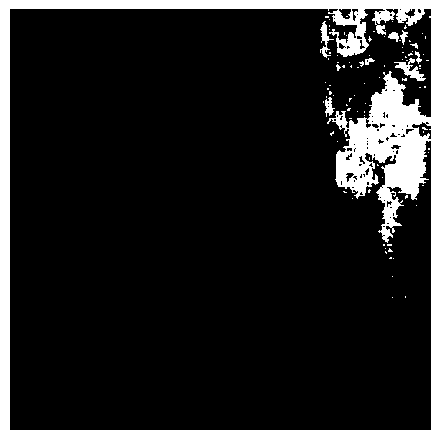

In [22]:
show_img(to_numpy(torch.sum(preds[0], dim=0) > 0, transpose=False))

#### Compare with batched SAM version

In [13]:
from src.commons.utils_io import load_sam
from src.models.commons.model import BiSam, SamModeInference
from src.commons.utils import batch_to_list

In [14]:
model_batched = load_sam(
    model_type="vit_b", model_cls=BiSam, version= "dev", device="cpu"
)

2024-07-18 14:30:37,579 - INFO ::  build vit_b BiSam


In [47]:
for i, batch in enumerate(dloader):
    if i==1:break

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48
/home/MDizier/data/dl/levir-cd/test/label/test_3.png
FIND SHAPES 7
/home/MDizier/data/dl/levir-cd/test/label/test_4.png
FIND SHAPES 11


In [36]:
batch["point_labels"][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int8)

In [37]:
batch["img_B"].shape

torch.Size([2, 3, 1024, 1024])

In [38]:
out = model_batched(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)

sparse_embeddings: torch.Size([2, 22, 2, 256])
dense_embeddings: torch.Size([2, 22, 256, 64, 64])


In [40]:
preds = (out["masks"] > 0.).squeeze(2)
print(preds.shape)

torch.Size([2, 22, 256, 256])


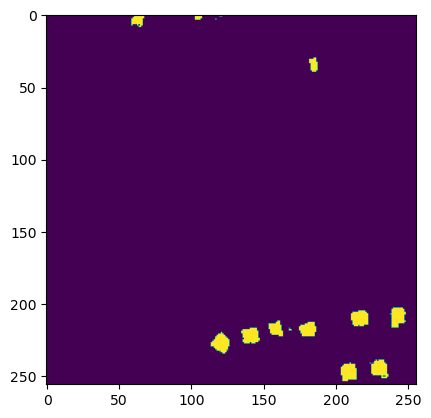

In [42]:
plt.imshow(to_numpy(torch.sum(preds[1], dim=0), transpose=False))

#### Test avec pad sequences pormpts

In [43]:
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr
from typing import Any, Dict, List, Tuple, Union

In [44]:
from typing import List, Tuple, Dict, Any
def collate_align_prompt(input: List[Any]):

    prompt_pts = [d["point_coords"] for d in input]
    prompt_labels = [d["point_labels"] for d in input]

    # we set -1 as value to ignore prompt
    batch_pts = pad_sequence(prompt_pts, batch_first=True, padding_value=torch.inf)
    # negative prompt : 0 is ignore - (same as positive prompt btw)
    batch_labels = pad_sequence(prompt_labels, batch_first=True, padding_value=0)

    for i in range(len(input)):
        input[i]["point_coords"] = batch_pts[i]
        input[i]["point_labels"] = batch_labels[i]

    return data._utils.collate.default_collate(input)

In [46]:
params = {
    "prompt_type": "sample",
    "n_prompt": 2,
    #"n_shape": 20,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48


TypeError: 'dict' object is not an iterator

In [ ]:
# points = batch["point_coords"].clone()
# points = torch.cat([points, torch.zeros((2, 10, 2))], dim=1)
# batch["point_coords"] = points
# batch["point_labels"] = torch.ones(points.shape[:2])

In [ ]:
batch["point_coords"]

Il n'y a pas 20 shapes dans l'image 1 donc il doit y avoir un tirage avec replacement => +sierus prompt par shape

In [48]:
out = model_batched(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)

sparse_embeddings: torch.Size([2, 22, 2, 256])
dense_embeddings: torch.Size([2, 22, 256, 64, 64])


In [49]:
preds = model_batched.upscale_masks(out["masks"], (1024, 1024))

In [50]:
preds[0].shape

torch.Size([22, 1, 1024, 1024])

In [53]:
preds[0]

tensor([[[[-12.9111, -12.9111, -12.9116,  ..., -12.6381, -12.5831, -12.5831],
          [-12.9111, -12.9111, -12.9116,  ..., -12.6381, -12.5831, -12.5831],
          [-12.9545, -12.9545, -12.9906,  ..., -12.6254, -12.5770, -12.5770],
          ...,
          [-12.8764, -12.8764, -13.0516,  ..., -13.5790, -13.6774, -13.6774],
          [-12.7521, -12.7521, -12.9581,  ..., -13.6387, -13.7711, -13.7711],
          [-12.7521, -12.7521, -12.9581,  ..., -13.6387, -13.7711, -13.7711]]],


        [[[-12.7013, -12.7013, -12.6726,  ..., -12.5029, -12.4574, -12.4574],
          [-12.7013, -12.7013, -12.6726,  ..., -12.5029, -12.4574, -12.4574],
          [-12.7251, -12.7251, -12.7311,  ..., -12.4796, -12.4392, -12.4392],
          ...,
          [-12.8111, -12.8111, -12.9621,  ..., -13.5091, -13.6053, -13.6053],
          [-12.6986, -12.6986, -12.8790,  ..., -13.5679, -13.6982, -13.6982],
          [-12.6986, -12.6986, -12.8790,  ..., -13.5679, -13.6982, -13.6982]]],


        [[[-13.4314, -13.4

In [27]:
preds = (preds > 0).squeeze(2)
print(preds.shape)

torch.Size([2, 96, 1024, 1024])


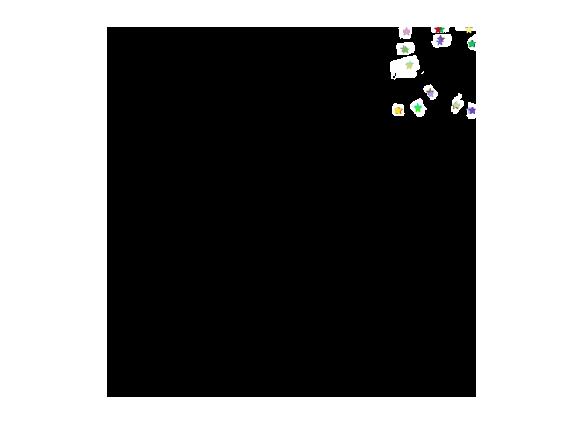

In [28]:
idx = 0
mask = torch.sum(preds[idx], dim=0) > 0
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

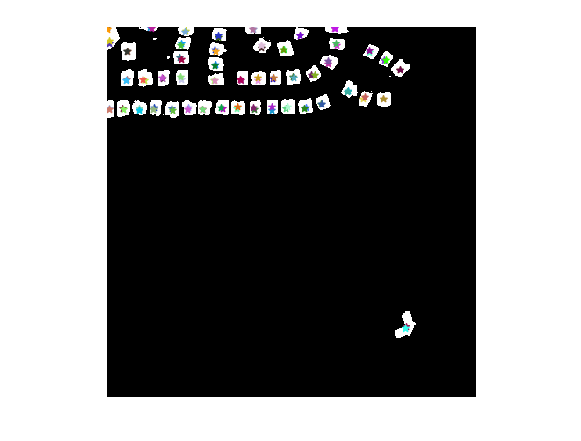

In [29]:
idx = 1
mask = torch.sum(preds[idx], dim=0) > 0
coord_points = batch["point_coords"][idx]
mask_pt = get_mask_with_prompt(mask, coord_points)
show_img(mask_pt)

In [109]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape": 50,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )
batch = next(iter(dloader))
out = model_batched(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = (out["masks"] > 0.).squeeze(2)

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48
sparse_embeddings: torch.Size([2, 50, 2, 256])
dense_embeddings: torch.Size([2, 50, 256, 64, 64])


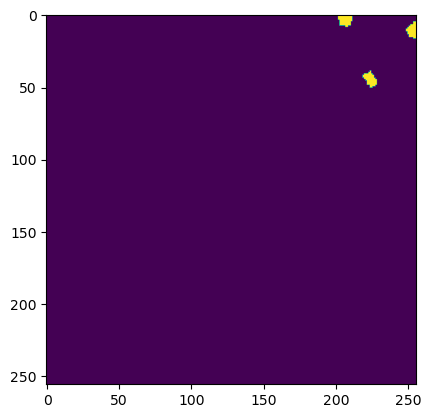

In [94]:
plt.imshow(to_numpy(torch.sum(preds[0], dim=0), transpose=False))

In [83]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":None,
    "loc": "center",
    "batch_size": 1,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )
batch = next(iter(dloader))
out = model_batched(batch, multimask_output=True, mode=SamModeInference.INTERACTIVE)
preds = (out["masks"] > 0.).squeeze(2)

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
sparse_embeddings: torch.Size([1, 12, 2, 256])
dense_embeddings: torch.Size([1, 12, 256, 64, 64])


In [84]:
idx_max = torch.argmax(out["iou_predictions"], dim=2)

In [85]:
idx_max.shape

torch.Size([1, 12])

In [86]:
preds.shape

torch.Size([1, 12, 3, 256, 256])

In [87]:
expanded_indices = idx_max.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 1, 256, 256)

# Use gather to select elements along dim 2
selected_elements = torch.gather(preds, 2, expanded_indices).squeeze(2)

In [88]:
out["iou_predictions"].shape

torch.Size([1, 12, 3])

In [89]:
selected_elements.shape

torch.Size([1, 12, 256, 256])

### One prompt on every label

Need to have batch_size == 1

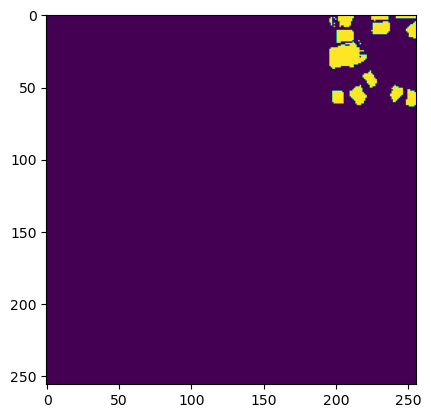

In [91]:
plt.imshow(to_numpy(torch.sum(selected_elements[0], dim=0), transpose=False))

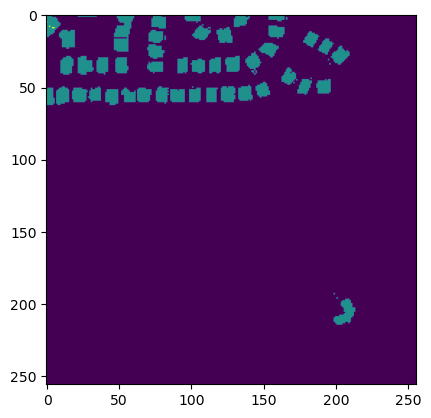

In [82]:
plt.imshow(to_numpy(torch.sum(selected_elements[1], dim=0), transpose=False))

### Review sampler

In [1]:
import torch
import os
from pathlib import Path
from typing import Any, Union
import numpy as np
import pandas as pd
from commons.constants import SECOND_NO_CHANGE_RGB, NamedDataset
from commons.constants import SECOND_PATH, LEVIRCD_PATH, SEED
from torch.utils.data import Dataset
import hydra
from torch.utils import data
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf

from src.data.process import DefaultTransform
from src.data.loader import BiTemporalDataset
from src.data.process import collate_align_prompt

In [2]:
params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":None,
    "loc": "random",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
            collate_fn=collate_align_prompt
        )


In [3]:
for i, batch in enumerate(dloader):
    pass

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12
/home/MDizier/data/dl/levir-cd/test/label/test_2.png
FIND SHAPES 48
/home/MDizier/data/dl/levir-cd/test/label/test_3.png
FIND SHAPES 7
/home/MDizier/data/dl/levir-cd/test/label/test_4.png
FIND SHAPES 11
/home/MDizier/data/dl/levir-cd/test/label/test_5.png
FIND SHAPES 13
/home/MDizier/data/dl/levir-cd/test/label/test_6.png
FIND SHAPES 6
/home/MDizier/data/dl/levir-cd/test/label/test_7.png
FIND SHAPES 133
/home/MDizier/data/dl/levir-cd/test/label/test_8.png
FIND SHAPES 57
/home/MDizier/data/dl/levir-cd/test/label/test_9.png
FIND SHAPES 9
/home/MDizier/data/dl/levir-cd/test/label/test_10.png
FIND SHAPES 105
/home/MDizier/data/dl/levir-cd/test/label/test_11.png
FIND SHAPES 14
/home/MDizier/data/dl/levir-cd/test/label/test_12.png
FIND SHAPES 104
/home/MDizier/data/dl/levir-cd/test/label/test_13.png
FIND SHAPES 80
/home/MDizier/data/dl/levir-cd/test/label/test_14.png
FIND SHAPES 107
/home/MDizier/data/dl/levir-cd/test/label/

In [36]:
batch["point_coords"][1].shape

torch.Size([11, 1024, 1024])

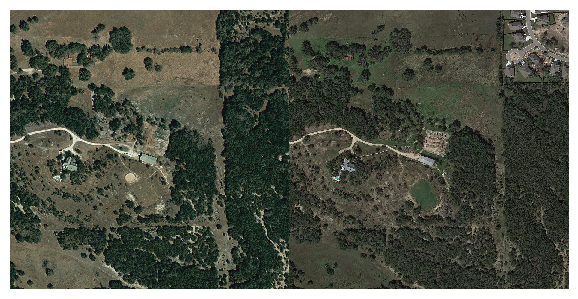

In [268]:
show_pair_img(to_numpy(batch["img_A"][0])/255, to_numpy(batch["img_B"][0])/255)

In [283]:
torch.tensor([torch.inf, torch.inf])

tensor([inf, inf])

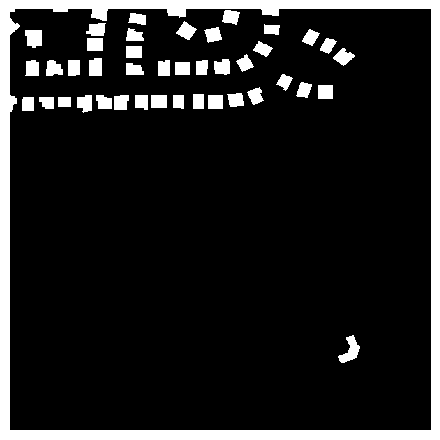

In [269]:
show_img(to_numpy(batch["label"][idx], transpose=False))

In [271]:
idx=0
label = batch["label"][idx]

In [18]:
def generate_prompt(
    mask, dtype: str, n_point: int, kwargs: Union[Dict, DictConfig]
) -> torch.Tensor:
    """Generate n_point prompts for a mask : grid or sample mode (dtype)"""
    img_size = mask.shape[-1]
    match dtype:
        case "grid":
            point_per_side = int(np.sqrt(n_point))
            prompt = torch.as_tensor(
                generate_grid_prompt(point_per_side, img_size=img_size)
            )
            labels = torch.ones(len(prompt))
        case "sample":
            loc = kwargs.get('loc', "center")
            n_shape = kwargs.get('n_shape', None)
            prompt, labels, mask = PointSampler().sample(mask=mask,  n_point_per_shape=n_point, loc=loc, n_shape=n_shape)
        case _:
            raise ValueError("Please provide valid prompt builder name")

    return prompt.to(torch.float32), labels.to(torch.int8), mask


In [24]:
from src.models.commons.mask_process import binarize_mask
from typing import Any, Dict, List, Optional, Tuple, Union
from deprecated import deprecated
from omegaconf import DictConfig
import torch
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils import data

from commons.constants import DEVICE, IMG_SIZE
from src.models.commons.mask_process import binarize_mask, extract_object_from_batch
from src.models.segment_anything.utils.transforms import ResizeLongestSide

from src.models.segment_anything.utils.amg import build_point_grid
from src.commons.utils import apply_histogram


In [69]:
class PointSampler:
    """Prompt sampler - restricted to points
    
    Each generated points is under coordinates format (X,Y) in pixels.
    """
    
    def __init__(self):
        self._register_sample_method = {
            "random": self.draw_random_point,
            "center": self.draw_center_point,
        }

    def sample_candidates_shapes(self, shapes: torch.Tensor, n_shape: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # assign equals weights
        probs = torch.ones(shapes.shape[0]) / shapes.shape[0]
        # Sample the shapes
        id_candidates_shapes = torch.multinomial(
            probs,
            n_shape,
            # we sample with replacement to keeping same tensor dimensions over batch if not enough shapes
            replacement=False if (shapes.shape[0] >= n_shape) else True,
        )
        # get the coord of the pixels shapes (M x 3) - M number of not zeros pixels
        coords_candidates = torch.nonzero(shapes[id_candidates_shapes]).to(torch.float)
        return coords_candidates, id_candidates_shapes
        
    def sample(self, mask: torch.Tensor,  n_point_per_shape: int, loc: str, n_shape: int=None):
        """
        Sample m points over n random shape
        Return new label if a subset of shapes (n_shape) is selected
        """

        if loc not in list(self._register_sample_method):
            raise ValueError(
                f"loc method not valid. Valid values for loc : {list(self._register_sample_method)}"
            )
        
        new_label = mask.clone()
        if mask.ndim < 3:
            mask = mask.unsqueeze(0)
        # track id shapes if we a subset of shapes
        id_selected_shapes = None
        
        # extract shapes from mask
        shapes = extract_object_from_batch(mask).squeeze(0)
        print("FIND SHAPES", shapes.shape[0])
        # if (n_shape is not None) and (n_shape != shapes.shape[0]):
        #     raise NotImplementedError("Sample of shapes is not implemented yet")

        # filter on areas
        areas = torch.sum(shapes, dim=(1, 2))
        indices = torch.where(areas > 150)[0]
        shapes = shapes[indices,:,:]
        
        # empty return
        n = n_shape if (n_shape) and (n_shape <= shapes.shape[0]) else shapes.shape[0]
        sample_coords = torch.zeros((n*n_point_per_shape, 2), dtype=torch.float32)
        # return shapes, torch.ones(shapes.shape[0]), torch.tensor([0])
        # check if there is some shapes extracted - check sum for no-shapes return - check > 1 first for speed in case of shapes
        if shapes.shape[0] > 1 or torch.sum(shapes):
            # set for all shapes if not specify
            if n_shape is not None:
                coords_candidates, id_selected_shapes = self.sample_candidates_shapes(shapes, n_shape)
            else:
                coords_candidates = torch.nonzero(shapes).to(torch.float)
            # first column of coords_candidates == index of shape
            # iterate over the shapes
            sample_coords = torch.cat(
                [
                    # mask coordinates based on shape index
                    # select only coordinates dims for _register_sample_method : [:, 1:] => (N, 2)
                    self._register_sample_method[loc](
                        coords_candidates[coords_candidates[:, 0] == s][:, 1:], n_point_per_shape
                    )
                    for s in torch.unique(coords_candidates[:, 0])
                ]
            )
        # simulate point type (foreground / background) - foreground default
        labels_points = torch.ones(len(sample_coords))

        if id_selected_shapes is not None:
            new_label = binarize_mask(torch.sum(shapes[id_selected_shapes], dim=0), th=0)

        return sample_coords, labels_points, new_label

    def draw_random_point(self, shape, n_point):
        """draw one random point from shape"""
        idx = torch.multinomial(
            torch.ones(shape.shape[0], dtype=torch.float), num_samples=n_point
        )
        # invert pixels coords to (x, y) format
        return torch.flip(shape[idx], dims=(1,))

    def draw_center_point(self, shape, n_point):
        """
        Sample approximation center. Proxy for hard concave object where "natural center" (simple average) doesn't belong to the shape.
        shape : (M, 2) : (shape's pixels, px coordinates dim)
        """
        # proxy for hard concave object
        visible_center = torch.mean(shape, dim=0).to(int)
        # euclidean distance
        dist_center = torch.cdist(visible_center.unsqueeze(0).to(torch.float), shape, p=1.).view(-1)
        # sample point from inverse distance weighting => in favor of "closest center" point - take first 50 pts arbitrary
        values, indices  = torch.topk(dist_center, min(50, dist_center.shape[0]), largest=False, sorted=True)
        values, indices = values.view(-1), indices.view(-1)
        print(shape.shape)
        idx = torch.multinomial(
            values, num_samples=n_point
        )
        # flip to convert to (x, y) format
        return torch.flip(shape[indices[idx]], dims=(1,))



In [70]:
pair_img = load_levircd_sample(1, seed=42)

In [71]:
path_label,path_A, path_B = pair_img.iloc[0]

label = load_img(path_label)

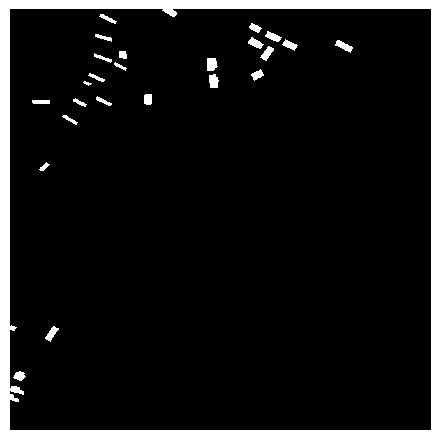

In [72]:
show_img(label)

In [73]:
res, _, n_label = generate_prompt(torch.as_tensor(label), dtype="sample", n_point=1, kwargs=dict(loc="center", n_shape=None))

FIND SHAPES 28
torch.Size([439, 2])
torch.Size([386, 2])
torch.Size([423, 2])
torch.Size([379, 2])
torch.Size([576, 2])
torch.Size([608, 2])
torch.Size([537, 2])
torch.Size([651, 2])
torch.Size([353, 2])
torch.Size([594, 2])
torch.Size([363, 2])
torch.Size([254, 2])
torch.Size([743, 2])
torch.Size([503, 2])
torch.Size([328, 2])
torch.Size([639, 2])
torch.Size([380, 2])
torch.Size([498, 2])
torch.Size([364, 2])
torch.Size([304, 2])
torch.Size([319, 2])
torch.Size([283, 2])
torch.Size([597, 2])
torch.Size([496, 2])
torch.Size([465, 2])
torch.Size([271, 2])


In [74]:
res.shape

torch.Size([26, 2])

In [53]:
print(torch.sum(res, dim=(1, 2)))

tensor([439., 386., 423., 379., 576., 608., 537., 651., 353., 594., 363., 254.,
        743., 503., 328., 136., 639., 380., 498., 364., 304., 319., 283., 146.,
        597., 496., 465., 271.])


In [65]:
areas = torch.sum(res, dim=(1, 2))

indices = torch.where(areas > 2000)[0]

res[indices,:,:].shape

torch.Size([0, 1024, 1024])

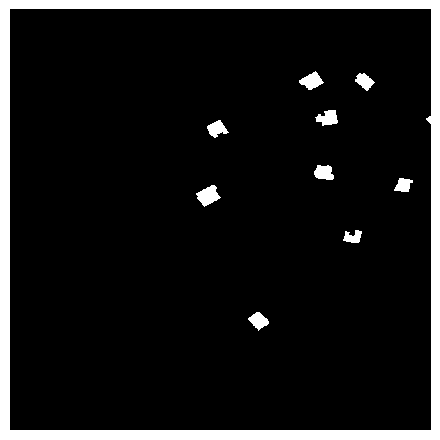

In [430]:
show_img(to_numpy(n_label.squeeze(0) > 0, transpose=False))

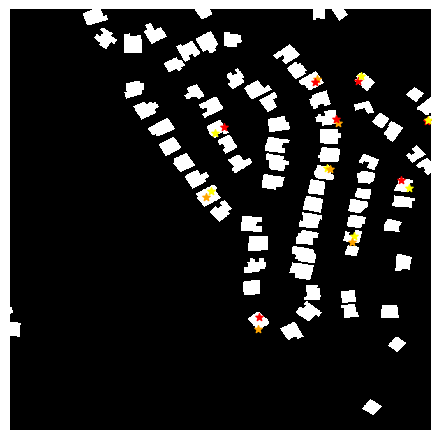

In [431]:
show_img(to_numpy(label.squeeze(0) > 0, transpose=False))
ax = plt.gca()
color = ["red", "yellow", "orange"] * len(res)
pts = to_numpy(res,transpose=False)
for pt,c in zip(pts, color):
    ax.scatter(*pt, color=c, marker='*', s=30)

In [5]:
import cv2

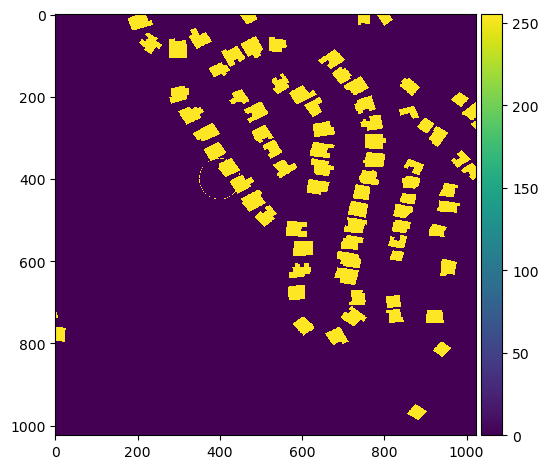

In [14]:
show_img(cv2.circle(to_numpy(label.squeeze(0), transpose=False), [400, 400], 50, color=255), -1)

### RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

### Define collate_fn for padding batch

---

In [449]:
from torch.utils import data

dloader = data.DataLoader(
            ds,  
            batch_size=1,
            shuffle=False,
            num_workers=params.get('num_worker', 0),
            # sampler=data.SequentialSampler(subset),
        )

In [450]:
batch = next(iter(dloader))

/home/MDizier/data/dl/levir-cd/test/label/test_1.png
FIND SHAPES 12


In [451]:
batch["label"].shape

torch.Size([1, 1024, 1024])

In [453]:
batch["img_A"].shape

torch.Size([1, 3, 1024, 1024])

In [458]:
from torchvision.utils import make_grid

label_ = torch.repeat_interleave(batch["label"], 3, dim=0)
grid = make_grid([batch["img_A"].squeeze(0), batch['img_B'].squeeze(0), label_], padding=2, pad_value=1)

torch.Size([3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


In [459]:
grid.shape

torch.Size([3, 1028, 3080])

2024-07-15 18:18:09,284 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


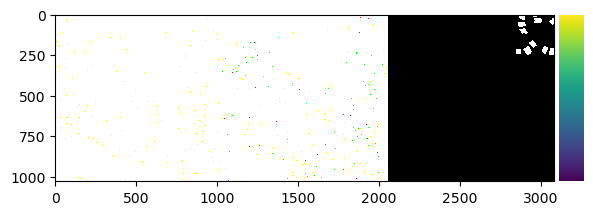

In [487]:
show_img(to_numpy(grid, transpose=True))

In [443]:
logits = torch.rand((1024, 1024))

torch.sigmoid(logits)

tensor([[0.6033, 0.6068, 0.6582,  ..., 0.6475, 0.5682, 0.5238],
        [0.5063, 0.6606, 0.5503,  ..., 0.6032, 0.6722, 0.5632],
        [0.6864, 0.6405, 0.5199,  ..., 0.6445, 0.6185, 0.6813],
        ...,
        [0.6167, 0.6433, 0.6084,  ..., 0.6474, 0.6666, 0.6305],
        [0.6882, 0.6647, 0.6676,  ..., 0.5991, 0.5587, 0.5629],
        [0.5169, 0.5359, 0.6061,  ..., 0.5173, 0.7161, 0.5788]])

In [439]:
from torchvision.utils import make_grid

batch["label"]

tensor([[[  0.,   0.,   0.,  ..., 255., 255., 255.],
         [  0.,   0.,   0.,  ..., 255., 255., 255.],
         [  0.,   0.,   0.,  ..., 255., 255., 255.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[255., 255., 255.,  ...,   0.,   0.,   0.],
         [255., 255., 255.,  ...,   0.,   0.,   0.],
         [255., 255., 255.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]])

In [ ]:
mask = label.clone()

if mask.ndim < 3:
    mask = mask.unsqueeze(0)

# extract shapes from mask
shapes = extract_object_from_batch(mask).squeeze(0)
print("FIND SHAPES", shapes.shape[0])

In [162]:
coords_candidates = torch.nonzero(shapes).to(torch.float)

In [245]:
coords_candidates.shape

torch.Size([102758, 3])

In [246]:
shape_test = coords_candidates[coords_candidates[:, 0] == 4][:, 1:]

In [247]:
shape_test

tensor([[ 34., 340.],
        [ 34., 341.],
        [ 34., 342.],
        ...,
        [ 83., 347.],
        [ 84., 344.],
        [ 84., 345.]])

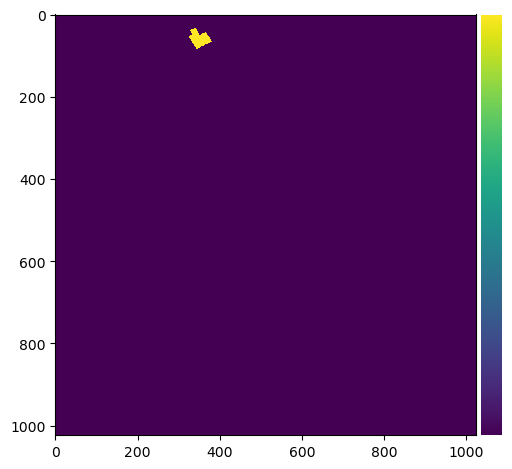

In [248]:
show_img(to_numpy(shapes[4], transpose=False))

In [167]:
shape_test.shape

torch.Size([1530, 2])

In [168]:
shape_test

tensor([[ 34., 340.],
        [ 34., 341.],
        [ 34., 342.],
        ...,
        [ 83., 347.],
        [ 84., 344.],
        [ 84., 345.]])

In [169]:
m=torch.mean(shape_test.to(torch.float), dim=0).to(int)
print(m.shape)
m

torch.Size([2])


tensor([ 59, 350])

In [170]:
torch.flip(m, dims=(0,))

tensor([350,  59])

In [171]:
shape_test.shape

torch.Size([1530, 2])

In [172]:
visible_center = torch.flip(torch.mean(shape_test.to(torch.float), dim=0).to(int), dims=(0,))

In [173]:
shape_test.dtype

torch.float32

In [174]:
dist_center = torch.cdist(visible_center.unsqueeze(0).to(torch.float), shape_test.unsqueeze(0))


In [175]:
idx = torch.multinomial(
    1/dist_center.squeeze(), num_samples=1
).squeeze(0)
idx

tensor(1381)

In [489]:
batch["point_coords"].shape

torch.Size([1, 3, 2])

In [ ]:
res.shape

In [185]:
# invert for sample

In [490]:
label.shape

torch.Size([1024, 1024])

In [485]:
show_img(to_numpy(label.squeeze(0) > 0, transpose=False))
ax = plt.gca()
color = ["red", "yellow", "orange"] * len(res)
pts = to_numpy(res,transpose=False)
for pt,c in zip(pts, color):
    ax.scatter(*pt[::-1], color=c, marker='*', s=30)
fig=plt.gcf()
plt.close()

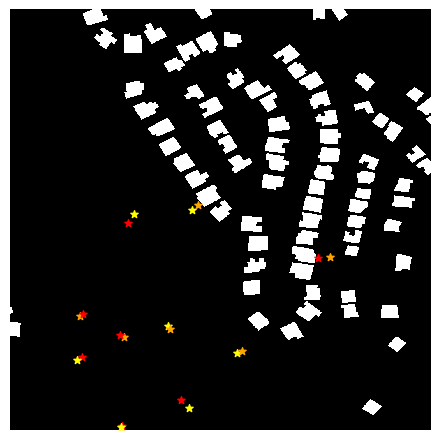

In [486]:
fig 

In [482]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    # keep first 3 dims
    return np.array(img)[:, :, :3]

arr = fig2img(fig)

In [491]:
from src.commons.utils import resize

In [496]:
arr.shape

(480, 640, 3)

In [500]:
arr_ = to_numpy(resize(arr.transpose(2, 0, 1), (1024, 1024)), transpose=True)

2024-07-15 18:32:16,529 - WARNING ::  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


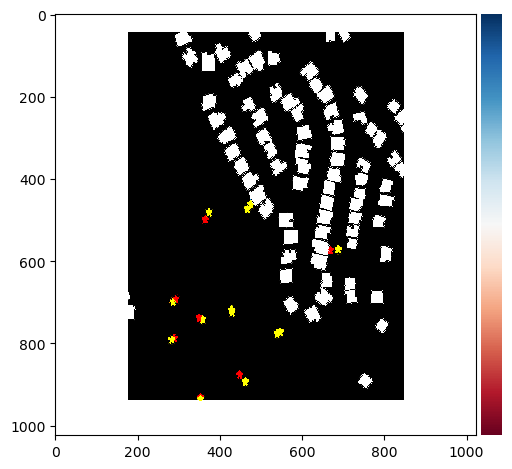

In [502]:
show_img(arr_)

In [469]:
from PIL import Image
Image.frombytes('RGB', fig.canvas.get_width_height(),fig.canvas.tostring_rgb())

ValueError: not enough image data

## Query Prompt

In [1]:
import torch
import numpy as np
import torch.nn.functional as F

from commons.constants import DEVICE, IMG_SIZE
from src.models.commons.mask_process import extract_object_from_batch
from src.models.segment_anything.utils.transforms import ResizeLongestSide

In [2]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
import torch
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ListProposal,
    change_thresholding,
)
from segment_any_change.matching import (
    neg_cosine_sim,
    neg_cosine_sim_torch,
)
from segment_any_change.sa_dev.utils.amg import MaskData
from segment_any_change.sa_dev_v0.predictor import SamPredictor

from segment_any_change.utils import to_degre, timeit, to_degre_torch
import logging



In [12]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.7,
    stability_score_thresh=0.8
)
params = load_exp_params(**params)
print(params)

res = partial_inference(params,
    ds_dtype="test",
    dummy=False,
    indices=np.arange(2),
    return_batch=True,
    in_metrics=None)

2024-06-21 09:11:11,922 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.7, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_091111', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')
DATASET SUBSET : 2


Processing:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]2024-06-21 09:11:13,367 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : auto
DTYPE input model torch.float32
Function forward Took 6.7005 seconds
sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
Function predict_masks_batch Took 60.0866 seconds
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
:: raw masks : 3072 ::
 filter iou_th : 2375
 filter stability_score : 751
 filter mask_threshold : 751
ATTACH 232 masks
:: raw masks : 3072 ::
 filter iou_th : 2005
 filter stability_score : 541
 filter mask_threshold : 541
ATTACH 336 masks
:: raw masks : 3072 ::
 filter iou_th : 2120


2024-06-21 09:12:20,781 - INFO ::  Function generate Took 67.4125 seconds


 filter stability_score : 612
 filter mask_threshold : 612
ATTACH 260 masks
:: raw masks : 3072 ::
 filter iou_th : 1687
 filter stability_score : 631
 filter mask_threshold : 631
ATTACH 402 masks


2024-06-21 09:12:24,139 - INFO ::  Function temporal_matching_torch Took 3.3524 seconds
2024-06-21 09:12:27,935 - INFO ::  Function temporal_matching_torch Took 3.7947 seconds
2024-06-21 09:12:27,960 - INFO ::  Function proposal_matching_nms Took 0.0091 seconds


NMS masks fusion
masks torch.Size([2, 260, 256, 256])
masks i A torch.Size([232, 256, 256])
masks i B torch.Size([260, 256, 256])
ci torch.Size([2, 260])
bboxes torch.Size([2, 260, 4])
ious torch.Size([2, 260])
masks_logits torch.Size([2, 260, 256, 256])


2024-06-21 09:12:32,780 - INFO ::  Function temporal_matching_torch Took 4.8028 seconds
2024-06-21 09:12:38,535 - INFO ::  Function temporal_matching_torch Took 5.7538 seconds
2024-06-21 09:12:38,564 - INFO ::  Function proposal_matching_nms Took 0.0106 seconds


NMS masks fusion
masks torch.Size([2, 402, 256, 256])
masks i A torch.Size([336, 256, 256])
masks i B torch.Size([402, 256, 256])
ci torch.Size([2, 402])
bboxes torch.Size([2, 402, 4])
ious torch.Size([2, 402])
masks_logits torch.Size([2, 402, 256, 256])


2024-06-21 09:12:39,103 - INFO ::  Function run Took 85.7348 seconds


update : classif


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [01:26<00:00, 86.71s/it]

-


In [13]:
res[0].keys()

dict_keys(['pred', 'metrics', 'batch'])

In [14]:
out = res[0]

---

In [6]:
from segment_any_change.model import BiSam, SamModeInference
from segment_any_change.utils import load_sam
from magic_pen.config import DEVICE

sam = load_sam(
    model_type="vit_h", 
    model_cls=BiSam, 
    version="dev", 
    device=DEVICE
)

2024-06-21 08:52:45,745 - INFO ::  build vit_h BiSam


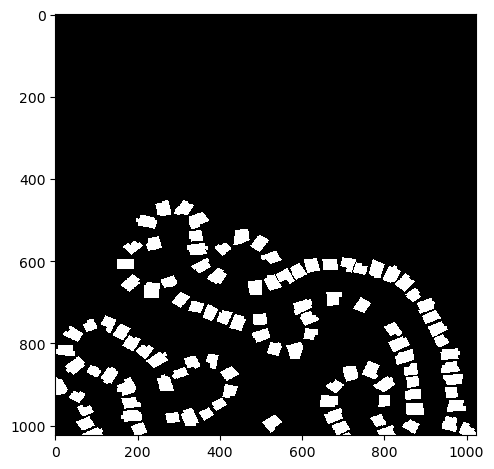

In [7]:
show_img(to_numpy(out["batch"]["label"][1].squeeze(0) > 0, transpose=False), show_axis=True)


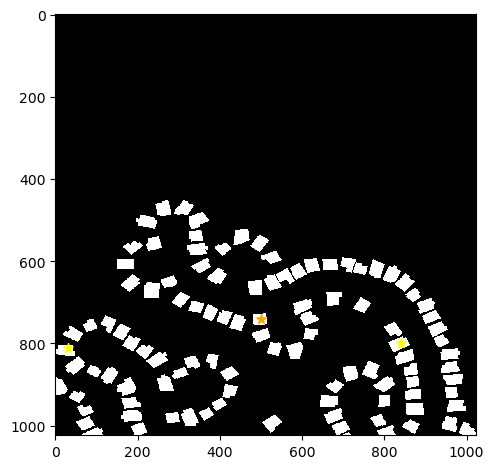

In [8]:
show_img(to_numpy(out["batch"]["label"][1].squeeze(0) > 0, transpose=False), show_axis=True)

ax = plt.gca()
n_pts = 3
color = ["yellow", "orange"] * n_pts
pts = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
for pt,c in zip(pts, color):
    ax.scatter(*pt[::-1], color=c, marker='*', s=50)

In [9]:
pts = pts[:, ::-1]
pts

array([[ 30, 810],
       [500, 740],
       [840, 800]])

In [10]:
new_batch = out["batch"].copy()

query_points = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
query_points = query_points[:, ::-1].copy()

new_batch["point_coords"] = torch.as_tensor(query_points, dtype=torch.float).repeat(params.batch_size, 1, 1)
new_batch["point_labels"] = torch.ones((params.batch_size, len(query_points)))

In [11]:
new_batch["point_coords"].shape

torch.Size([2, 3, 2])

In [12]:
new_batch["img_B"].shape

torch.Size([2, 3, 1024, 1024])

In [13]:
outputs = sam(
    batched_input=new_batch, 
    multimask_output=True, 
    return_logits=True,
    mode=SamModeInference.INTERACTIVE
)
new_masks, iou_predictions = outputs.values()
new_masks = new_masks > 0.
# prevent image encoder to recompute images embeddings

Mode : auto
DTYPE input model torch.float32
Function forward Took 15.1186 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1830 seconds


In [14]:
new_masks.shape

torch.Size([2, 3, 3, 256, 256])

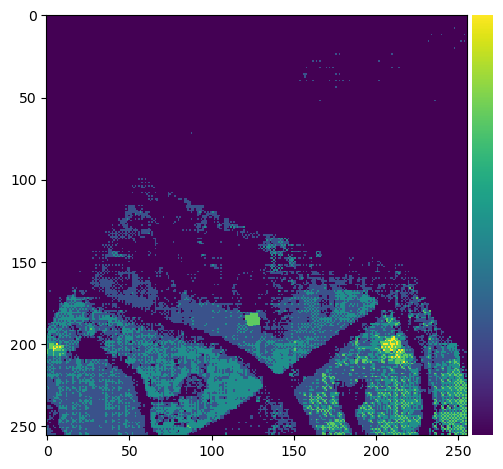

In [17]:
show_img(to_numpy(new_masks[1].flatten(0, 1).sum(dim=0), transpose=False))

In [18]:
iou_predictions.shape

torch.Size([2, 3, 3])

In [19]:
torch.argmax(iou_predictions, dim=2, keepdim=True).shape

torch.Size([2, 3, 1])

In [20]:
_, max_indices = torch.max(iou_predictions, dim=2)


In [21]:
new_masks.shape

torch.Size([2, 3, 3, 256, 256])

In [22]:
max_indices_expanded = max_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, *new_masks.shape[-2:])
max_indices_expanded.shape


torch.Size([2, 3, 1, 256, 256])

In [23]:
best_masks = new_masks.gather(2, max_indices_expanded).squeeze(2)

In [24]:
best_masks.shape

torch.Size([2, 3, 256, 256])

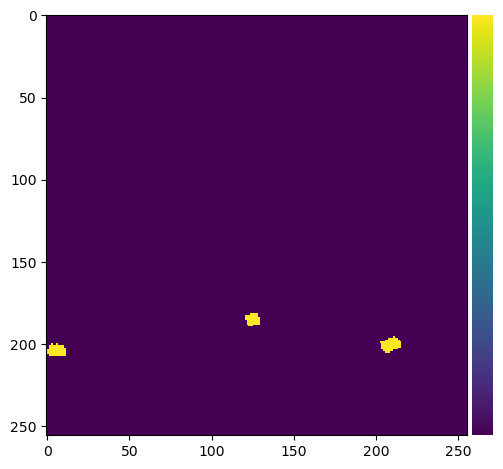

In [25]:
show_img(to_numpy(best_masks[1].sum(dim=0), transpose=False))

In [26]:
best_masks.shape

torch.Size([2, 3, 256, 256])

In [27]:
from segment_any_change.masks.mask_items import ImgType

def get_img_embedding_normed(model: Any, img_type: ImgType=None) -> torch.Tensor:
    """Invert affine transformation of the image encoder last LayerNorm Layer.
    Run for a batch


    Args:
        predictor (SamPredictor, BiSam): inference class for SAM

    Returns:
        np.ndarray: Scaled embedding
    """
    # workaround BiSam - not clean
    if type(model).__name__ == "BiSam":
        embedding = model.get_image_embedding(img_type)
        print(embedding.shape)
    else:
        raise RuntimeError(f"Not implemented for {type(model).__name__}")
    # check for batch ==1
    # get last layerNorm weights & biais to invert affine transformation
    w = model._modules["image_encoder"].neck[3].weight
    b = model._modules["image_encoder"].neck[3].bias
    embedding = (embedding - b[:, None, None]) / w[:, None, None]
    return embedding.detach()

In [28]:
imgs_embedding_B = get_img_embedding_normed(sam)

torch.Size([2, 256, 64, 64])


In [29]:
imgs_embedding_B.shape

torch.Size([2, 256, 64, 64])

In [30]:
best_masks.shape

torch.Size([2, 3, 256, 256])

In [31]:
# imgB at position 1 in batch best_masks

In [32]:
masks_embedding = compute_mask_embedding(best_masks, imgs_embedding_B)

In [47]:
# mean of embedding
masks_embedding = masks_embedding.mean(dim=1)


In [48]:
masks_embedding.shape

torch.Size([2, 256])

In [49]:
masks_embedding.mean(dim=1).shape

torch.Size([2])

In [50]:
out["pred"].keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [51]:
proposal_emb = out["pred"]["proposal_emb"]

In [52]:
proposal_emb.shape

torch.Size([2, 46, 256])

In [53]:
proposal_emb.sum(dim=(2))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.3351e-05,  1.2159e-05,  1.5259e-05,  1.0133e-05,  2.6226e-06,
         -1.1206e-05,  4.0531e-05,  1.6928e-05,  1.1921e-05,  9.0599e-06,
          1.3113e-05, -1.3590e-05,  4.4823e-05,  3.5763e-05,  4.8637e-05,
          5.1498e-05,  4.3154e-05,  1.7166e-05,  3.0696e-05,  4.7684e-06,
          3.3379e-05,  1.2398e-05,  1.5736e-05, -8.8573e-05,  2.1458e-06,
          8.5831e-06,  5.7220e-06,  7.6294e-06,  1.4305e-06,  4.7684e-07,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5538e-05,
          3.7432e-05,  3.5763e-06,  1.4544e-05, -6.4373e-05, -4.1008e-05,
         -1.8597e-05,  5.1022e-05, -5.7220e-06, -1.2875e-05,  1.3828e-05,
          4.0531e-05,  9.0599e-06,  4.1246e-05,  4.6492e-05, -3.1233e-05,
         -2.360

In [56]:
masks_embedding.shape

torch.Size([2, 256])

In [57]:
proposal_emb.shape

torch.Size([2, 46, 256])

In [64]:
torch.linalg.norm(masks_embedding[1])

tensor(12.6350)

In [65]:
x1 = masks_embedding[1]
x2 = proposal_emb[1]

norm_1 = torch.linalg.norm(x1)
norm_2 = torch.linalg.norm(x2, dim=1)

dot_prod = (x1 @ x2.permute(1, 0))
# vectors norms with expanded dims
dot_prod

tensor([  0.0000,   0.0000,   0.0000,   0.0000,  -5.5923,  -5.1457, -16.9344,
        -17.3297,  14.2962,   6.3296,   6.1532,  -2.2355,  11.0176,  12.6313,
         -5.1123,  -4.2284,  -4.2299,  -4.9053,   5.4207,  -1.6285,  -1.0752,
        -17.0602,  -2.1242, -17.3310,  -5.1744,  -5.3159, -15.8345,   5.9231,
        -11.9830, -10.5392, -11.4093, -10.6340, -10.9885, -11.7309,  -7.2686,
        -16.5317, -14.4801,   0.6191,  -0.3936,  -9.5159,  -0.3905,  -5.0292,
        -10.3664,  -4.6749,  -6.2325,  -4.2766])

In [83]:
norm_1

tensor(12.6350)

In [84]:
norm_1 * norm_2

tensor([  0.0000,   0.0000,   0.0000,   0.0000, 151.1815, 147.5632, 198.8871,
        198.2207, 163.0387, 177.0507, 175.9531, 154.3141, 185.3502, 181.3557,
        169.0987, 159.5884, 166.2843, 180.1351, 168.9056, 124.7338, 178.7722,
        194.6823, 136.6943, 159.6251, 160.3629, 166.2133, 181.8186, 145.6011,
        199.3010, 186.2363, 191.9364, 184.4159, 179.7820, 190.8785, 157.6511,
        194.7347, 197.1313, 129.2035, 151.0691, 169.2456, 152.0373, 163.4092,
        172.6324, 160.0476, 152.9678, 156.1759])

In [85]:
norm_1.unsqueeze(0).unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2

tensor([[  0.0000,   0.0000,   0.0000,   0.0000, 151.1815, 147.5632, 198.8871,
         198.2207, 163.0387, 177.0507, 175.9531, 154.3141, 185.3502, 181.3557,
         169.0987, 159.5884, 166.2843, 180.1351, 168.9056, 124.7338, 178.7722,
         194.6823, 136.6943, 159.6251, 160.3629, 166.2133, 181.8186, 145.6011,
         199.3010, 186.2363, 191.9364, 184.4159, 179.7820, 190.8785, 157.6511,
         194.7347, 197.1313, 129.2035, 151.0691, 169.2456, 152.0373, 163.4092,
         172.6324, 160.0476, 152.9678, 156.1759]])

In [82]:
norm_2

tensor([ 0.0000,  0.0000,  0.0000,  0.0000, 11.9653, 11.6789, 15.7409, 15.6882,
        12.9037, 14.0127, 13.9258, 12.2132, 14.6696, 14.3534, 13.3833, 12.6307,
        13.1606, 14.2568, 13.3681,  9.8721, 14.1490, 15.4082, 10.8187, 12.6336,
        12.6919, 13.1550, 14.3901, 11.5236, 15.7737, 14.7397, 15.1908, 14.5956,
        14.2289, 15.1071, 12.4773, 15.4123, 15.6020, 10.2258, 11.9564, 13.3950,
        12.0330, 12.9331, 13.6630, 12.6670, 12.1067, 12.3606])

In [81]:
x1 = masks_embedding[1]
x2 = proposal_emb[1]

norm_1 = torch.linalg.norm(x1)
norm_2 = torch.linalg.norm(x2, dim=1)

dot_prod = (x1 @ x2.permute(1, 0))
# vectors norms with expanded dims
#dm = norm_1.unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2.unsqueeze(0).expand(norm_1.shape[0], -1)
dm = norm_1.unsqueeze(0).unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2
(dot_prod / dm).shape

torch.Size([1, 46])

In [39]:
norm_1 = torch.linalg.norm(x1, dim=1)
print(norm_1)
norm_1.unsqueeze(1).expand(-1, norm_2.shape[0])

tensor([13.4766, 12.8870, 13.0592])


tensor([[13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766],
        [12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870],
        [13.0592, 13.0592, 13.0592, 13.0592, 13.0592, 13.0592,

In [40]:
x2[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

proposal embedding could be 0 ??
* => a cause du pad_sequence ?

In [35]:
from magic_pen.utils_io import save_pickle, load_pickle

save_pickle(out, "tmp.pkl")

### test

In [1]:
from segment_any_change.query_prompt import QueryPointMecanism, SegAnyPrompt

ImportError: cannot import name 'ListProposal' from 'segment_any_change.masks.mask_items' (/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/masks/mask_items.py)

In [ ]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample

from magic_pen.utils_io import save_pickle, load_pickle

from segment_any_change.inference import partial_inference, infer_on_sample

pl.seed_everything(seed=SEED)

In [3]:
out = load_pickle("tmp.pkl")

In [4]:
out["pred"].keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [5]:
data = out["pred"]["data"]

In [6]:
out["pred"]["proposal_emb"].shape

torch.Size([2, 407, 256])

In [7]:
from segment_any_change.model import BiSam, SamModeInference
from segment_any_change.utils import load_sam
from magic_pen.config import DEVICE

sam = load_sam(
    model_type="vit_h", 
    model_cls=BiSam, 
    version="dev", 
    device=DEVICE
)

2024-06-21 09:54:05,606 - INFO ::  build vit_h BiSam


In [62]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.7,
    stability_score_thresh=0.8
)
params = load_exp_params(**params)
print(params)

ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=0, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.7, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_100306', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


In [63]:
items_change = out["pred"]

new_batch = out["batch"].copy()

query_points = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
query_points = query_points[:, ::-1].copy()

new_batch["point_coords"] = torch.as_tensor(query_points, dtype=torch.float).repeat(params.batch_size, 1, 1)
new_batch["point_labels"] = torch.ones((params.batch_size, len(query_points)))

query_engine = QueryPointMecanism(items_change, model=sam, th_sim=85)

In [52]:
items_change.keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [53]:
query_res = query_engine.run(new_batch)

Mode : auto
DTYPE input model torch.float32
Function forward Took 13.1205 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1453 seconds
torch.Size([2, 256])
torch.Size([2, 407, 256])
2
torch.Size([407, 1024, 1024])
torch.Size([407])
torch.Size([407, 1024, 1024])
torch.Size([407])


Objets changeants similaires aux prompts

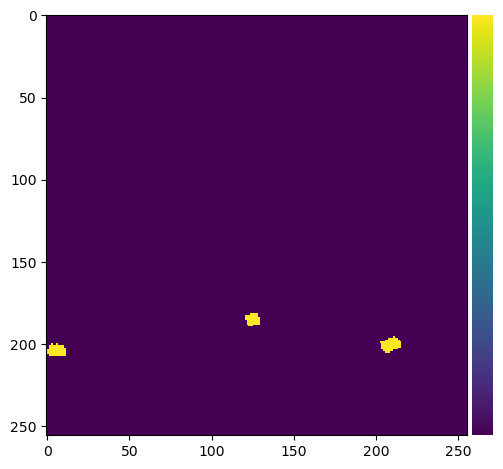

In [59]:
show_img(to_numpy(query_res["prompt_masks"][1].sum(dim=0), transpose=False))

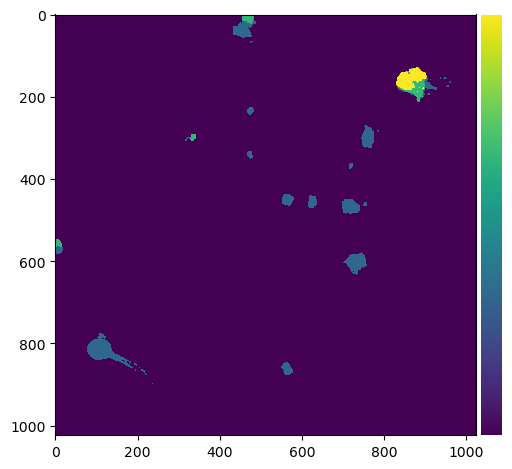

In [60]:
show_img(to_numpy(query_res["masks"][1].sum(dim=0), transpose=False))

Tout changements

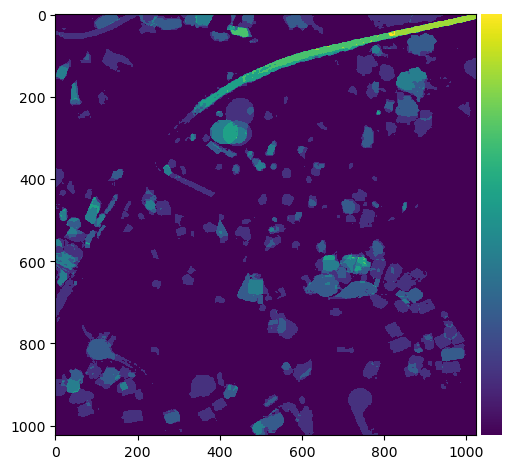

In [61]:
show_img(to_numpy(out["pred"]["masks"][1].sum(dim=0), transpose=False))

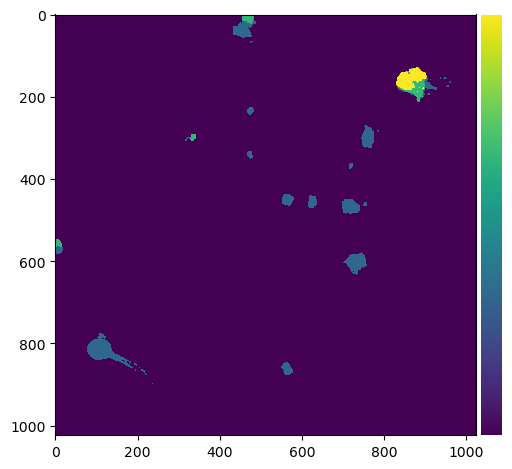

In [106]:
show_img(to_numpy(query_res["masks"][1].sum(dim=0), transpose=False)) 

In [ ]:
query_res.shape

In [ ]:
query_res["masks"].shape

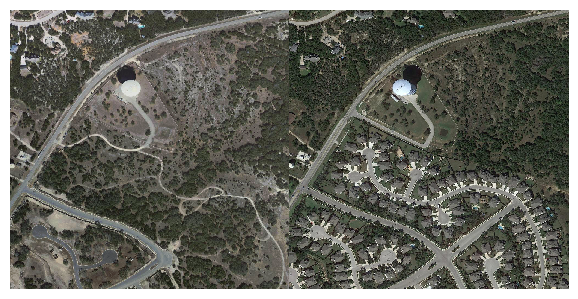

In [31]:
show_pair_img(to_numpy(new_batch["img_A"][1] / 255, transpose=True), to_numpy(new_batch["img_B"][1] / 255, transpose=True))

In [64]:
query_res["prompt_masks"].shape

torch.Size([2, 3, 256, 256])

In [70]:
from segment_any_change.utils import resize

p_masks = resize(query_res["prompt_masks"], (1024, 1024))


In [78]:
p_masks.shape

torch.Size([2, 3, 1024, 1024])

In [66]:
query_res["masks"].shape

torch.Size([2, 22, 1024, 1024])

In [84]:
t = torch.cat([query_res["masks"], p_masks], dim=1)

In [87]:
query_res["masks"][0].sum(dim=(1, 2))

tensor([519, 327, 558, 110, 896,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

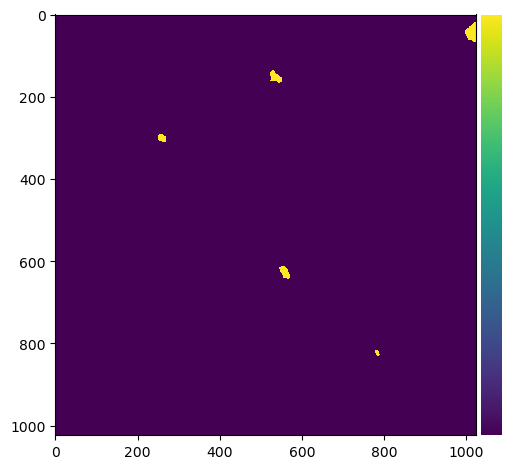

In [94]:
show_img(to_numpy(query_res["masks"][0].sum(dim=0), transpose=False))

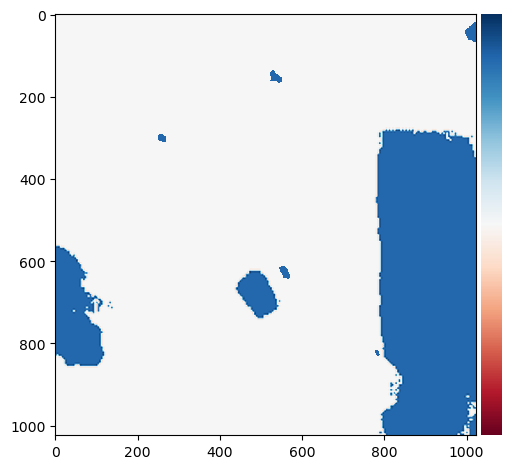

In [95]:
show_img(to_numpy(t[0].sum(dim=0), transpose=False))